# Test latest lmfit with new quickfit
https://lmfit.github.io/lmfit-py/model.html

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

In [2]:
# This needs to go into a separate cell: https://github.com/jupyter/notebook/issues/3385
plt.rcParams['figure.figsize'] = [9.5, 6] # for slightly bigger plots

In [3]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

def poly2(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2

In [4]:
#gmodel = Model(gaussian) + Model(poly2)  #bad fit!
gmodel = Model(gaussian)

In [5]:
gmodel.param_names

['amp', 'cen', 'wid']

In [6]:
gmodel.independent_vars

['x']

In [7]:
params = gmodel.make_params()

In [8]:
xdat = np.arange(-1,1,.01)
gdat = gaussian(xdat, 1, 0, .1)

<IPython.core.display.Javascript object>


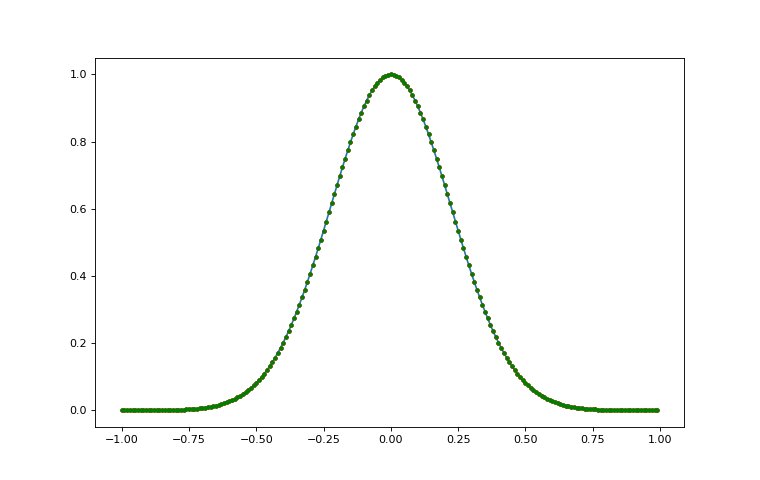

In [9]:
from IPython.display import display

fig = plt.figure()
aXis = fig.add_subplot(111)
_ = aXis.plot(xdat, gdat)

In [10]:
import sys
sys.path.append('/dls_sw/i16/software/python')

#import dlstools.quickfit

import numpy as np


def peak(xdat, ydat, nbgpts=1):
    '''
    [centre, fwhm_sd, fwhm_area, sum, height, area, m, c]=peak(x,y,nbgpts=1)
    Returns centre, fwhm_sd, fwhm_area, sum, height, area after subtracting a sloping
    linear background from the fist and nbgpts data points and the background parameters (m, c)
    fwhm_sd is from standard deviation (correct for gaussian)
    fwhm_area is from area/height (correct for gaussian) - more robust than sd with noisy data
    xdat, ydat are 1d arrays or lists
    '''
    x = np.array(xdat); 
    y = np.array(ydat); 
    npts = len(x); 
    xspan= x[-1] - x[0]			#copy data into arrays
    m = (np.mean(y[npts-nbgpts:npts]) - np.mean(y[0:nbgpts]))/(np.mean(x[npts-nbgpts:npts]) - np.mean(x[0:nbgpts]))    #slope for linear b/g
    c = np.mean(y[0:nbgpts]) - np.mean(x[0:nbgpts])*m	#intercept
    y = y - m * x - c;			#subtract background
    sumdat = sum(y);			#peak sum
    area = sumdat * xspan/npts;		#peak integral
    centre = sum(x*y)/sumdat;		#centroid calc.
    height = max(y);			#max y value after linear b/g
    fwhm_sd = np.sqrt(sum((x - centre)**2*y)/sumdat) * np.sqrt(8*np.log(2))
    fwhm_area = area/height * 0.3989 * np.sqrt(8*np.log(2))
    
    return dict(cen=centre, fwhm_sd=fwhm_sd, fwhm=fwhm_area, sum=sumdat, amp=height, area=area, m=m, c=c)
 
### some pre-defined peak and background functions

def gauss(x, area, cen, fwhm):
    return area/fwhm*np.sqrt(4*np.log(2)/np.pi)*np.exp(-4*np.log(2)*((x-cen)/fwhm)**2)

def lorentz(x, area, cen, fwhm):
    return area/fwhm/(np.pi/2)/(1+4*((x-cen)/fwhm)**2)

def pvoigt(x, area, cen, fwhm, lfrac):
    return area/fwhm/(lfrac*np.pi/2+(1-lfrac)*np.sqrt(np.pi/4/np.log(2)))*(lfrac/(1+4*((x-cen)/fwhm)**2)+(1-lfrac)*np.exp(-4*np.log(2)*((x-cen)/fwhm)**2))

def poly2(x, m, c):
    return m * x + c

def const(x, c):
    return c

g_c = Model(gauss) + Model(const)
g_lin = Model(gauss) + Model(poly2)
lor_c = Model(lorentz) + Model(const)
lor_lin = Model(lorentz) + Model(poly2)
pv_c = Model(pvoigt) + Model(const)
pv_lin = Model(pvoigt) + Model(poly2)

def fit(func, aXis):
    xData, yData = aXis.get_lines()[0].get_xydata().transpose()
  
    xL, xU = aXis.get_xlim()
    iI = (xData >= xL) & (xData <= xU)
    xData, yData = xData[iI], yData[iI]

    pk_prms = peak(xData, yData)
    
    _prms = func.make_params()
    
    # assign fit parameter value to parameters that match the parameters from peak with others defaulting to zero
    for key in _prms.keys():
        try:
            _prms[key].value = pk_prms[key]
        except:
            _prms[key].value = 0

    result =  func.fit(yData, x=xData, params = _prms)   #do the fit 

    outstr = func.name+'\n\n'
    for pname in result.params:
        prm = result.params[pname]
        try:
            stderr = prm.stderr
            _n_dec_places = max(0, int(-np.round(np.log10(stderr))) + 1)
        except:
            stderr = 0
            _n_dec_places = 4 # in case parameter not varied then stderr is zero

        _fmt='%.' + str(_n_dec_places) + 'f'
        outstr+='%10s:  ' % prm.name + '%15s' % (_fmt % prm.value)+' +/- '+ '%-10s' % str(_fmt % stderr) +'\n'

    print(outstr+'\n')
    
    return (xData, func.eval(x=xData, params=result.params))



In [11]:
result = fit(pv_c, aXis)
_ = aXis.plot(result[0], result[1], 'r.')

#display(fig) # -> only when in matplotlib inline mode

(Model(pvoigt) + Model(const))

      area:    0.56049912053 +/- 0.00000000012
       cen:   -0.00000000072 +/- 0.00000000008
      fwhm:    0.52655376956 +/- 0.00000000012
     lfrac:   -0.00000000281 +/- 0.00000000009
         c:    0.00000000030 +/- 0.00000000009




In [12]:
import sys
if sys.version_info[0] < 3:
    sys.path.append('/dls_sw/i16/software/python')
    sys.path.append('/dls_sw/apps/scisoftpy/2.7')
    from dlstools.pdnx import * # code here is not 
    p='/dls/i16/data/2019/mm22314-1/%i.nxs'
    datadir='/dls/i16/data/2019/mm22314-1/'
    

=== Importing dlstools package


In [13]:
if sys.version_info[0] < 3:
    n=pdnx(p % 759623)
    n

/dls_sw/i16/software/python/dlstools/pdnx.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  setattr(self,'nx',_nx)


<IPython.core.display.Javascript object>


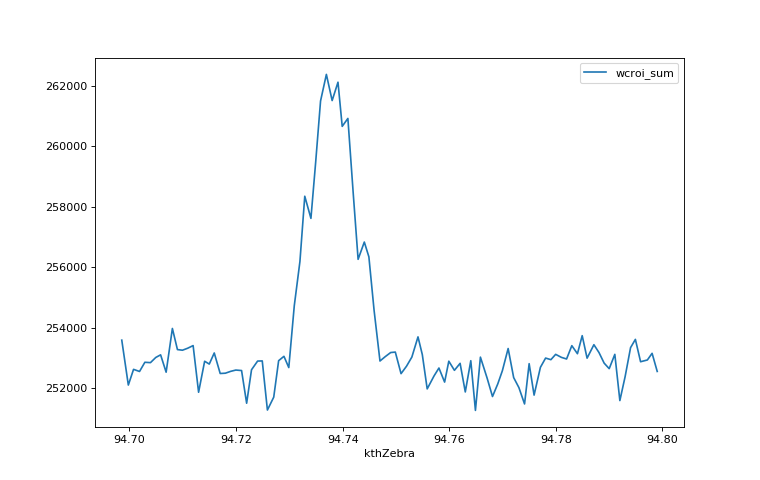

In [14]:
if sys.version_info[0] < 3:
    n.plot('kthZebra', 'wcroi_sum')

In [15]:
#click on plot to do fit
result = fit(g_lin, aXis)
_ = aXis.plot(result[0], result[1], 'g.')

#display(fig) # -> only when in matplotlib inline mode

(Model(gauss) + Model(poly2))

      area:    0.56049912166 +/- 0.00000000011
       cen:   -0.00000000062 +/- 0.00000000007
      fwhm:    0.52655376951 +/- 0.00000000011
         m:   -0.00000000032 +/- 0.00000000005
         c:   0.000000000091 +/- 0.000000000011


